## Create JSON metadata for cropped FOV

In [1]:
from starfish.experiment.builder import TileFetcher, FetchedTile

In [2]:
import io
import os
import shutil
from typing import IO, Mapping, Tuple, Union

from skimage.io import imread
from slicedimage import ImageFormat

from starfish.experiment.builder import FetchedTile, TileFetcher, write_experiment_json
from starfish.types import Coordinates, Indices, Number

SHAPE = 1000, 800


class BaristaSeqTile(FetchedTile):
    def __init__(self, file_path):
        self.file_path = file_path

    @property
    def shape(self) -> Tuple[int, ...]:
        return SHAPE

    @property
    def coordinates(self) -> Mapping[Union[str, Coordinates], Union[Number, Tuple[Number, Number]]]:
        # these are dummies
        return {
            Coordinates.X: (0.0, 0.0001),
            Coordinates.Y: (0.0, 0.0001),
            Coordinates.Z: (0.0, 0.0001),
        }
    
    @property
    def format(self) -> ImageFormat:
        return ImageFormat.TIFF

    @property
    def tile_data(self) -> IO:
        return imread(self.file_path)


class BaristaSeqTileFetcher(TileFetcher):
    def __init__(self, input_dir):
        self.input_dir = input_dir

    def get_tile(self, fov: int, hyb: int, ch: int, z: int) -> FetchedTile:
        subdir = 'primary'
        round_dir = f'r{hyb}'
        if hyb == 0:
            filename = f'T{fov+1:05}C{ch+1:02}Z{z+1:03}.tif'
        else:
            filename = f'alignedT{fov+1:05}C{ch+1:02}Z{z+1:03}.tif'
        file_path = os.path.join(self.input_dir, subdir, round_dir, filename)
        return BaristaSeqTile(file_path)


class BaristaSeqNucleiTileFetcher(TileFetcher):
    def __init__(self, input_dir, aux_type):
        self.input_dir = input_dir

    def get_tile(self, fov: int, hyb: int, ch: int, z: int) -> FetchedTile:
        subdir = 'nissl'
        filename = f'T00001C05Z{z+1:03}.tif'
        file_path = os.path.join(self.input_dir, subdir, filename)

        return BaristaSeqTile(file_path)


def format_data(input_dir, output_dir):
    def add_codebook(experiment_json_doc):
        # this just needs to be copied over, but here we make the link
        experiment_json_doc['codebook'] = "codebook.json"
        return experiment_json_doc

    num_fovs = 1

    primary_image_dimensions = {
        Indices.ROUND: 3,
        Indices.CH: 4,
        Indices.Z: 17,
    }

    aux_name_to_dimensions = {
        'nuclei': {
            Indices.ROUND: 1,
            Indices.CH: 1,
            Indices.Z: 17,
        }
    }

    write_experiment_json(
        path=output_dir,
        fov_count=num_fovs,
        primary_image_dimensions=primary_image_dimensions,
        aux_name_to_dimensions=aux_name_to_dimensions,
        primary_tile_fetcher=BaristaSeqTileFetcher(input_dir),
        aux_tile_fetcher={
            'nuclei': BaristaSeqNucleiTileFetcher(input_dir, 'nuclei'),
        },
        postprocess_func=add_codebook,
        default_shape=SHAPE
    )

In [7]:
input_dir = '/Users/ambrosecarr/Downloads/BaristaSeq/files_and_metadata/cropped'
output_dir = '/Users/ambrosecarr/Downloads/BaristaSeq/files_and_metadata/cropped_formatted'
os.makedirs(output_dir, exist_ok=True)

### Format the data. 

In [6]:
format_data(input_dir, output_dir)
shutil.copy(
    src=os.path.join(input_dir, 'codebook.json')
    dst=os.path.join(output_dir, 'codebook.json')
)

## Update the codebook from version 1

In [10]:
import json
with open('/Users/ambrosecarr/Downloads/BaristaSeq/files_and_metadata/codebook.json', 'rb') as f:
    codebook = json.load(f)

In [13]:
v0_0_0_codebook = {}
v0_0_0_codebook['mappings'] = codebook
v0_0_0_codebook['version'] = '0.0.0'

In [15]:
with open(os.path.join(output_dir, 'codebook.json'), 'w') as f:
    json.dump(v0_0_0_codebook, f)

## Try to load the data

In [23]:
import starfish
from starfish import Experiment
from starfish.types import Indices

In [16]:
exp = Experiment.from_json(
    '/Users/ambrosecarr/Downloads/BaristaSeq/files_and_metadata/cropped_formatted/'
    'experiment.json'
)

In [19]:
fov = exp['fov_000']

In [20]:
img = fov.primary_image
nissl = fov['nuclei']  # this is actually dots, should change this. 

100%|██████████| 17/17 [00:00<00:00, 140.19it/s]


## Max Project

In [24]:
proj = fov.primary_image.max_proj(Indices.Z)
proj = proj.reshape(3, 4, 1, 1000, 800)
projected_stack = starfish.ImageStack.from_numpy_array(proj)

100%|██████████| 12/12 [00:00<00:00, 38597.89it/s]


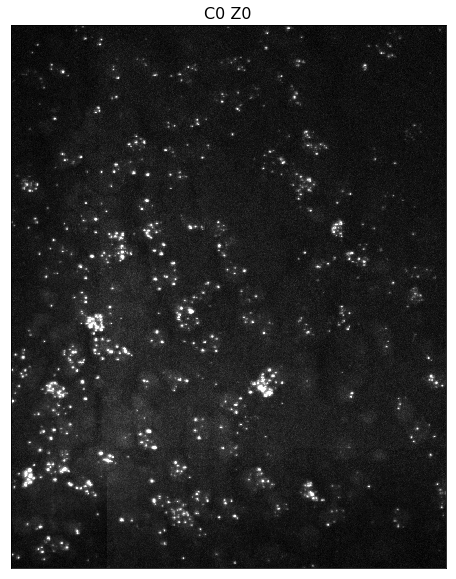

<function starfish.imagestack.imagestack.ImageStack._show_matplotlib_inline.<locals>.display_slice(plane_index=0)>

In [25]:
projected_stack.show_stack({Indices.ROUND: 0}, rescale=True, clim=)

## Translate the C channel to match input data

This one is happening in-place for now. 

In [26]:
from skimage.transform import AffineTransform, warp
from tqdm import tqdm
transform = AffineTransform(translation=(1.9, -0.4))  # this is due to the alignment of the filter for this channel

from itertools import product
import numpy as np
channels = (0,)
rounds = np.arange(img.num_rounds)
slice_indices = product(channels, rounds)

for ch, round_, in slice_indices:
    indices = {Indices.CH: ch, Indices.ROUND: round_}
    tile = projected_stack.get_slice(indices)[0]
    transformed = warp(tile, transform)
    projected_stack.set_slice(indices, transformed.astype(np.float32))

## Median Filter

In [27]:
from starfish.types import Indices
import scipy.signal
import skimage.filters
import warnings

# this might not be critical, it's designed to remove camera noise. Ask Deep about replacing or reimplementing without the cast to uint8
def median_filter(projected_stack):
    with warnings.catch_warnings():
#         warnings.simplefilter('ignore', UserWarning)  # casts to uint8 (but matlab doesn't do this)
#         return skimage.filters.median(projected_stack)
        return scipy.signal.medfilt(projected_stack)


median_filtered = projected_stack.apply(median_filter, in_place=False, verbose=True)

12it [00:01,  9.70it/s]


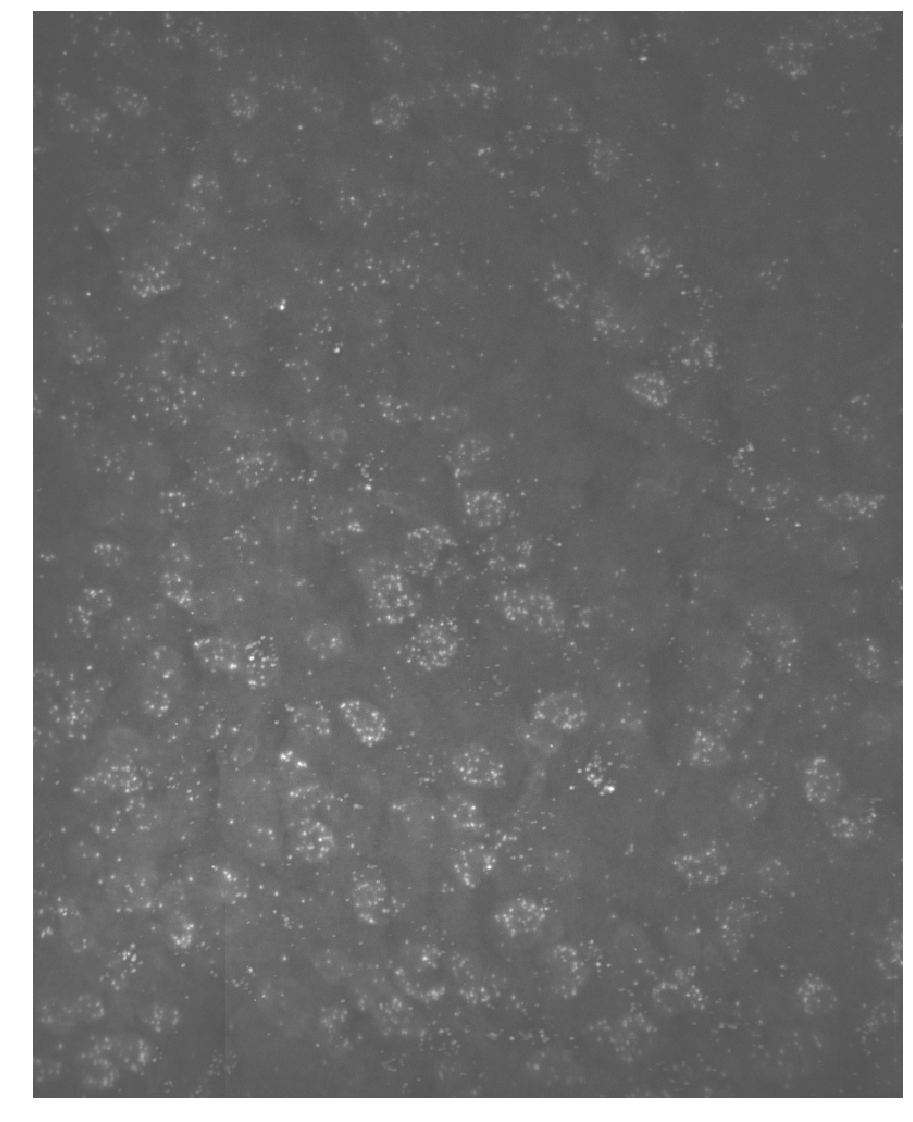

In [131]:
showit.image(projected_stack.max_proj(Indices.ROUND, Indices.CH)[0], size=20, clim=(0, 0.005))

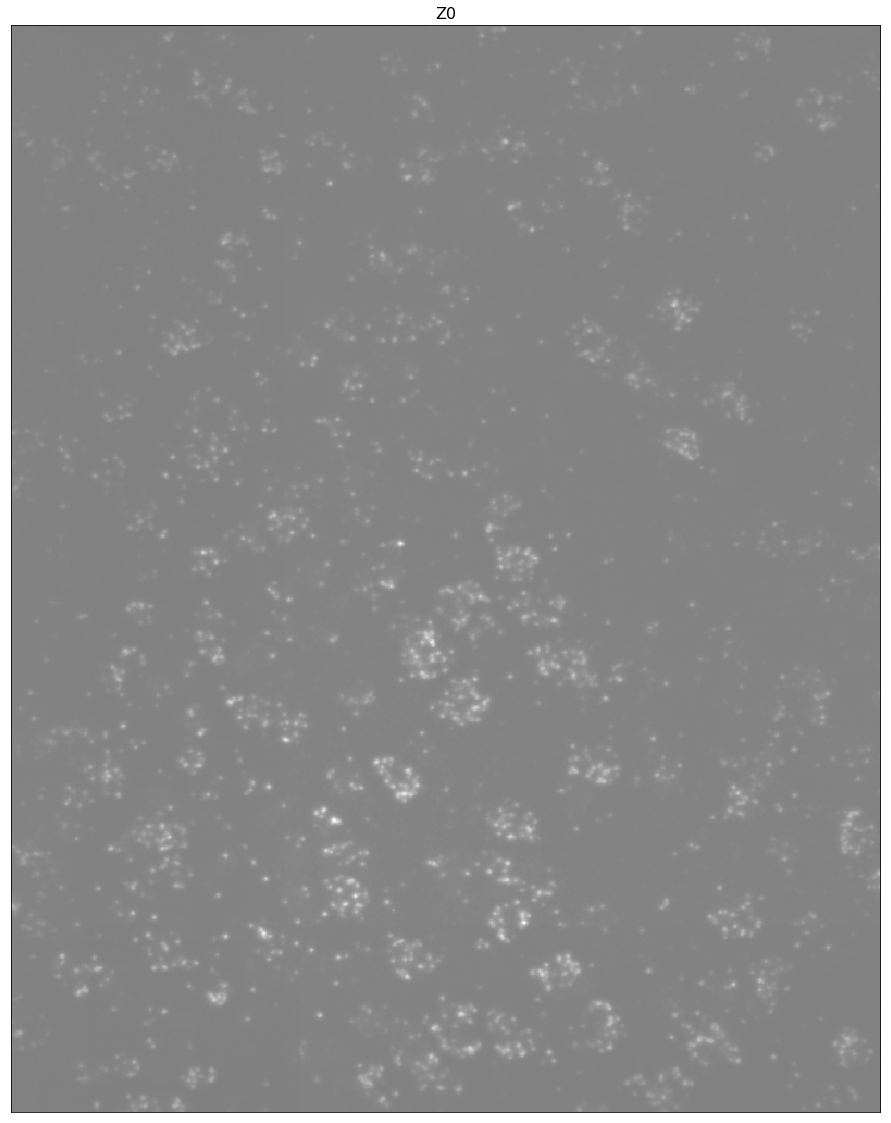

<function starfish.imagestack.imagestack.ImageStack._show_matplotlib_inline.<locals>.display_slice(plane_index=0)>

In [121]:
median_filtered.show_stack({Indices.ROUND: 2, Indices.CH: 1}, figure_size=(20, 20))

## Instead, Low pass the data to remove camera noise

In [29]:
glp = starfish.image.Filter.GaussianLowPass(sigma=1)
low_passed = glp.run(projected_stack, in_place=False)

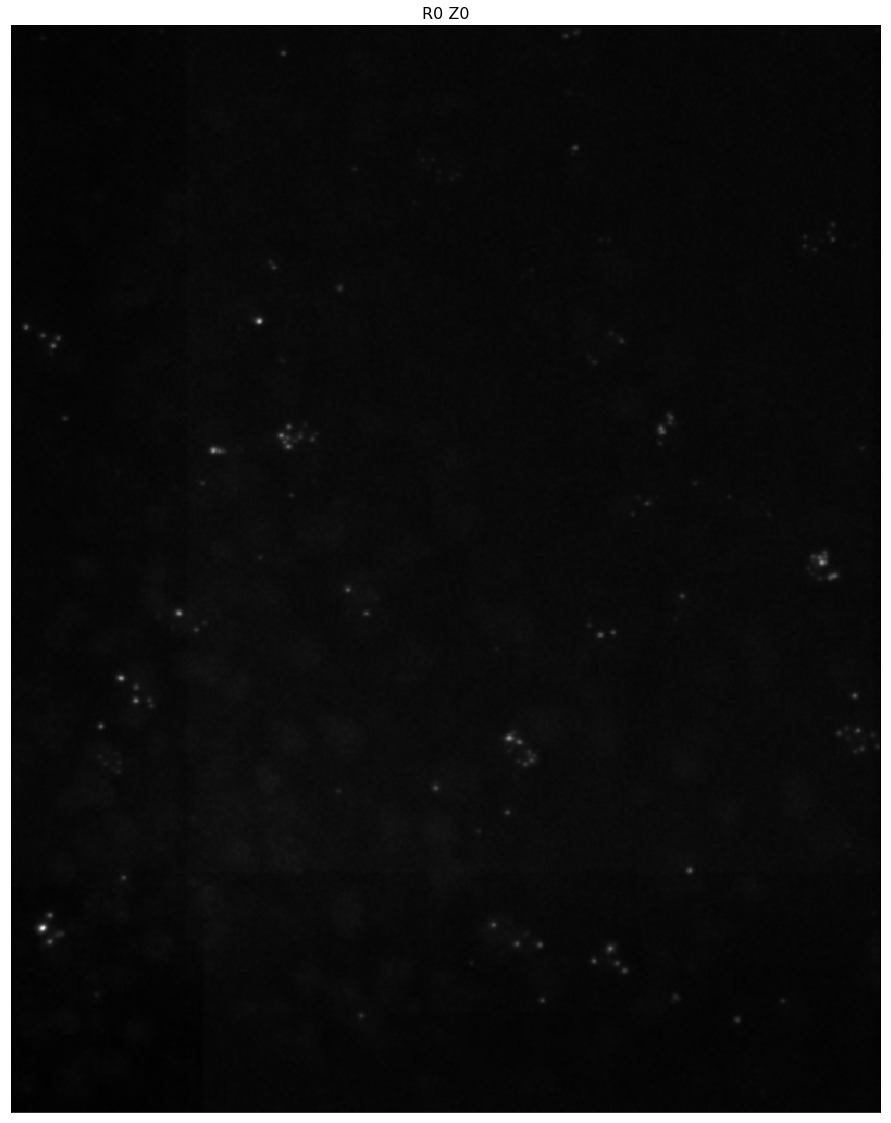

<function starfish.imagestack.imagestack.ImageStack._show_matplotlib_inline.<locals>.display_slice(plane_index=0)>

In [38]:
low_passed.show_stack({Indices.CH: 1}, figure_size=(20, 20))

## Do bleed corrections

Unfortunately, the data for this is in the _full_ experiment. Get the size factors from there!

In [31]:
import json

uncropped_experiment_json = '/Users/ambrosecarr/Downloads/BaristaSeq/files_and_metadata/experiment.json'
with open(uncropped_experiment_json, 'r') as f: 
    uncropped_experiment_data = json.load(f)

In [32]:
bleed_correction_factors = uncropped_experiment_data['extras']['channel_scale_factors']

In [33]:
bleed_correction_factors

[[0, 1, 0.05],
 [0, 2, 0.0],
 [0, 3, 0.0],
 [1, 0, 0.35],
 [1, 2, 0.0],
 [1, 3, 0.0],
 [2, 0, 0.0],
 [2, 1, 0.02],
 [2, 3, 0.84],
 [3, 0, 0.0],
 [3, 1, 0.0],
 [3, 2, 0.05]]

In [34]:
import copy
from tqdm import tqdm
import numpy as np
# make a new object for out-of-place

def do_bleed_correction(stack):
    bleed_corrected = copy.deepcopy(stack)

    for ch1, ch2, constant in tqdm(bleed_correction_factors):
        bleed = stack.get_slice({Indices.CH: ch1})[0] * constant
        img_to_correct = stack.get_slice({Indices.CH: ch2})[0]
        corrected = np.maximum(img_to_correct - bleed, 0)
        bleed_corrected.set_slice({Indices.CH: ch2}, corrected)
    return bleed_corrected

bleed_corrected = do_bleed_correction(low_passed)

100%|██████████| 12/12 [00:00<00:00, 49.22it/s]


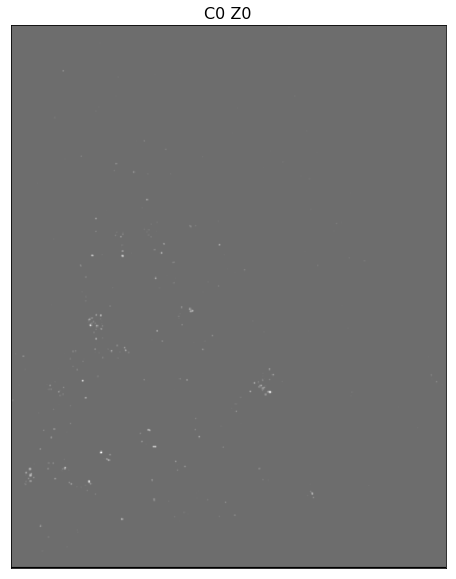

<function starfish.imagestack.imagestack.ImageStack._show_matplotlib_inline.<locals>.display_slice(plane_index=0)>

In [35]:
bleed_corrected.show_stack({Indices.ROUND: 0})

## Extract the background (morphological opening)

In [36]:
import skimage.morphology

def opening(image):
    # ball is extremely slow, using disk instead
    selem = skimage.morphology.disk(radius=20)
    background = skimage.morphology.opening(image, selem=selem)
    return np.maximum(image - background, 0)

background_subtracted = bleed_corrected.apply(opening, in_place=False, verbose=True, is_volume=False)

12it [00:05,  2.18it/s]


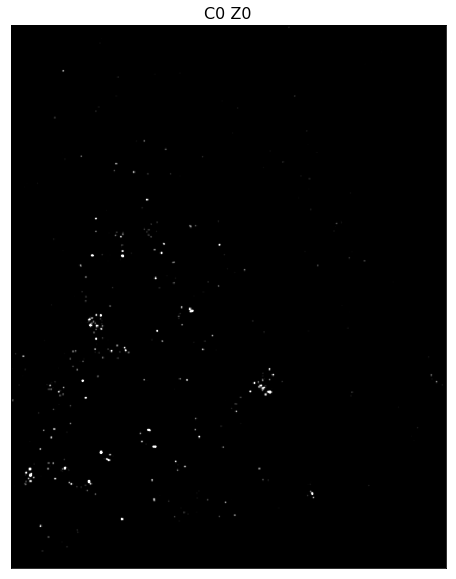

<function starfish.imagestack.imagestack.ImageStack._show_matplotlib_inline.<locals>.display_slice(plane_index=0)>

In [37]:
background_subtracted.show_stack({Indices.ROUND: 0}, rescale=True)

## Registration

They do some registration pre-processing: Channel 3 is translated down 1000 intensity: `np.maximum(0, img - 1000)`
Channel 1 is multiplied by 5. 

Question for Xiaoyin: What's the point of these modifications? 

In [39]:
from starfish.image import Registration

Registration is necessary. To do the alignment in the small tiles is challenging because there are potentially large shifts in stage alignment across rounds, and so registration benefits from a large image space. In this case, registration worked, with shifts of about ~40-50 pixels. But that may not always be the case, so they are currently using the pre-stitched images from their microscope's software for alignment.

In the long term, looking at the smaller tiles may give better results (no stitching errors) (can result in doubling of spots) -- this would certainly screw up segmentation.

In [40]:
round_1 = background_subtracted.get_slice({Indices.ROUND: 0})[0].reshape(1, 4, 1, 1000, 800)
registration_reference_stack = starfish.ImageStack.from_numpy_array(round_1)

100%|██████████| 4/4 [00:00<00:00, 5389.40it/s]


In [41]:
reg = Registration.FourierShiftRegistration(upsampling=1, reference_stack=registration_reference_stack)

In [42]:
registered = reg.run(background_subtracted)

For round: 0, Shift: [0. 0.], Error: 2.1073424255447017e-08
For round: 1, Shift: [39. 53.], Error: 0.6300350829187562
For round: 2, Shift: [39. 51.], Error: 0.6696192182391187


To check this, sum the images across channels before and after, look at a small subset of the data and check the cell positioning. 

In [43]:
import pandas as pd
# # not being done anymore; was being done because the channel was very noisy. 
# read each of the channels
# ch3 = np.maximum(ch3 - 1000, 0) * 1.2
# ch1 *= 5
# understand why this is being done? 
ch_data = {}
for ch_num in np.arange(registered.num_chs):
    data = registered.get_slice({Indices.CH: ch_num})[0]
    ch_data[ch_num] = pd.Series(np.ravel(data)).describe()

In [44]:
ch_data

{0: count    2.400000e+06
 mean     3.359875e-07
 std      9.760171e-06
 min      0.000000e+00
 25%      0.000000e+00
 50%      4.433664e-23
 75%      2.249719e-21
 max      1.478811e-03
 dtype: float64, 1: count    2.400000e+06
 mean     2.648316e-05
 std      5.692273e-05
 min      0.000000e+00
 25%      7.457566e-06
 50%      1.203024e-05
 75%      1.927969e-05
 max      1.585532e-03
 dtype: float64, 2: count    2.400000e+06
 mean     2.197493e-05
 std      4.401546e-05
 min      0.000000e+00
 25%      8.330098e-06
 50%      1.398730e-05
 75%      2.397670e-05
 max      2.907625e-03
 dtype: float64, 3: count    2.400000e+06
 mean     4.225551e-05
 std      7.124276e-05
 min      0.000000e+00
 25%      1.467299e-05
 50%      2.450380e-05
 75%      4.200148e-05
 max      2.118073e-03
 dtype: float64}

## Find Rolonies

Authors use FIJI rolony finding. This method takes a blob size and an aboslute tolerance which defines the (subtractive) difference between the maximum and the (local) background. 

In [45]:
from starfish.spots import SpotFinder

In [46]:
test_image = registered.get_slice({Indices.ROUND: 0, Indices.CH: 0})[0]

(array([7.95648e+05, 1.39900e+03, 7.20000e+02, 5.05000e+02, 3.38000e+02,
        2.41000e+02, 1.99000e+02, 1.61000e+02, 1.11000e+02, 1.09000e+02,
        7.40000e+01, 8.60000e+01, 5.80000e+01, 5.10000e+01, 4.00000e+01,
        3.40000e+01, 3.10000e+01, 2.70000e+01, 3.00000e+01, 2.90000e+01,
        1.50000e+01, 1.60000e+01, 8.00000e+00, 5.00000e+00, 8.00000e+00,
        6.00000e+00, 5.00000e+00, 5.00000e+00, 8.00000e+00, 3.00000e+00,
        3.00000e+00, 4.00000e+00, 2.00000e+00, 2.00000e+00, 2.00000e+00,
        2.00000e+00, 2.00000e+00, 3.00000e+00, 1.00000e+00, 3.00000e+00,
        2.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0.0000000e+00, 2.9576229e-05, 5.9152459e-05, 8.8728688e-05,
        1.1830492e-04, 1.4788115e-04, 1.7745738e-04, 2.0703360e-04,
        2.3660983e-04, 2.6618608e-04, 2.9576229e-04, 3.2533854e-04,
        3.5491475e-04, 3.8449100e-04, 4.1406721e-04, 4.4364345e-

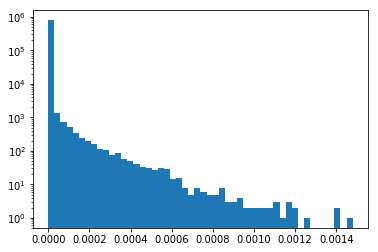

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(np.ravel(test_image), log=True, bins=50)

In [418]:
SpotFinder.GaussianSpotDetector()

starfish.spots._detector.SpotFinder

In [48]:
lmpf = SpotFinder.LocalMaxPeakFinder(spot_diameter=11, min_mass=0.01, max_size=100, separation=11 * 1.5, is_volume=False, preprocess=False, noise_size=[0, 0, 0])

In [243]:
# Their spots are about 7 pixels
# Bleed through isn't always completely corrected. In these cases there can be small (1.5px) shifts across channels
# to correct for this, merge rolonies within 1.5px of each other. 

# doing the max projection could result in information loss because the per-channel information might allow separation of rolonies that are 
# overlaping in the max projection, but separate in channel space. 

# If the channels are not balanced (one is noisy) then you hurt the weaker channels. 

In [61]:
codebook = starfish.Codebook.from_code_array(v0_0_0_codebook['mappings'])

In [87]:
mp = registered.max_proj(Indices.Z, Indices.CH, Indices.ROUND)

In [103]:
psd = SpotFinder.PixelSpotDetector(
    codebook=codebook,
    metric='euclidean', distance_threshold=0.517, magnitude_threshold=0.0005, min_area=4, max_area=50, norm_order=2
)

In [104]:
intensities, ccdr = psd.run(registered)

100%|██████████| 736/736 [00:01<00:00, 435.01it/s]


In [132]:
# non-rigid ICP will be needed for this data. 

In [ ]:
# Is there a multiplication between the codebook and the image intensity values that could be used to visualize a given code? 

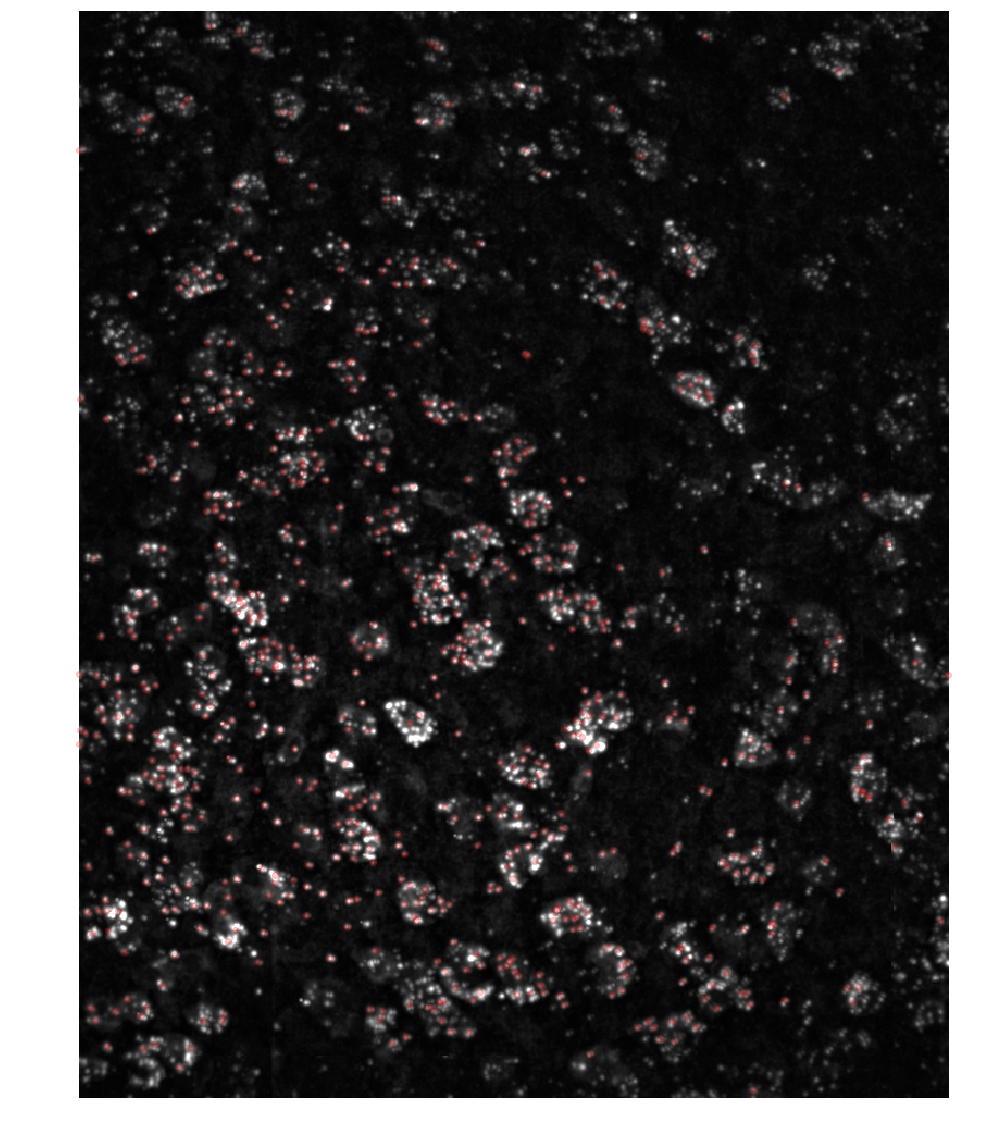

In [118]:
import showit
showit.image(mp, size=20, clim=(0, 0.001))
plt.scatter(intensities['x'], intensities['y'], alpha=0.2, c='r')

In [116]:
lmpf = starfish.spots.SpotFinder.LocalMaxPeakFinder(spot_diameter=7, min_mass=0.0001, max_size=100, separation=0.5, noise_size=(1, 1), is_volume=False)
results = lmpf.run(registered)

ValueError: Length mismatch: Expected axis has 8 elements, new values have 9 elements

In [75]:
intensities[0].shape

(252, 4, 3)

In [ ]:
results = {}

In [338]:
# write a spot detector
rounds = np.arange(registered.num_rounds)
channels = np.arange(registered.num_chs)
slice_indices = product(channels, rounds)
for ch, round_ in slice_indices:
    results[ch, round_] = skimage.feature.blob_log(
        registered.get_slice({Indices.CH: ch, Indices.ROUND: round_})[0], 
        min_sigma=0.2, max_sigma=4, num_sigma=30, threshold=0.0003, overlap=0.5, log_scale=False
    )
    break

In [ ]:
# Just loop over channels

In [341]:
channels = np.arange(registered.num_chs)
round_ = 0
for ch in channels:
    results[ch, round_] = skimage.feature.blob_log(
        registered.get_slice({Indices.CH: ch, Indices.ROUND: round_})[0], 
        min_sigma=0.2, max_sigma=4, num_sigma=30, threshold=0.0003, overlap=0.5, log_scale=False
    )

In [326]:
def plot_on_image(image, results):
    """results is from blob_log, image should be a 2d-image"""
    showit.image(image, size=20, clim=(0, 0.05))
    plt.scatter(results[:, 2], results[:, 1], alpha=0.4, c='r')

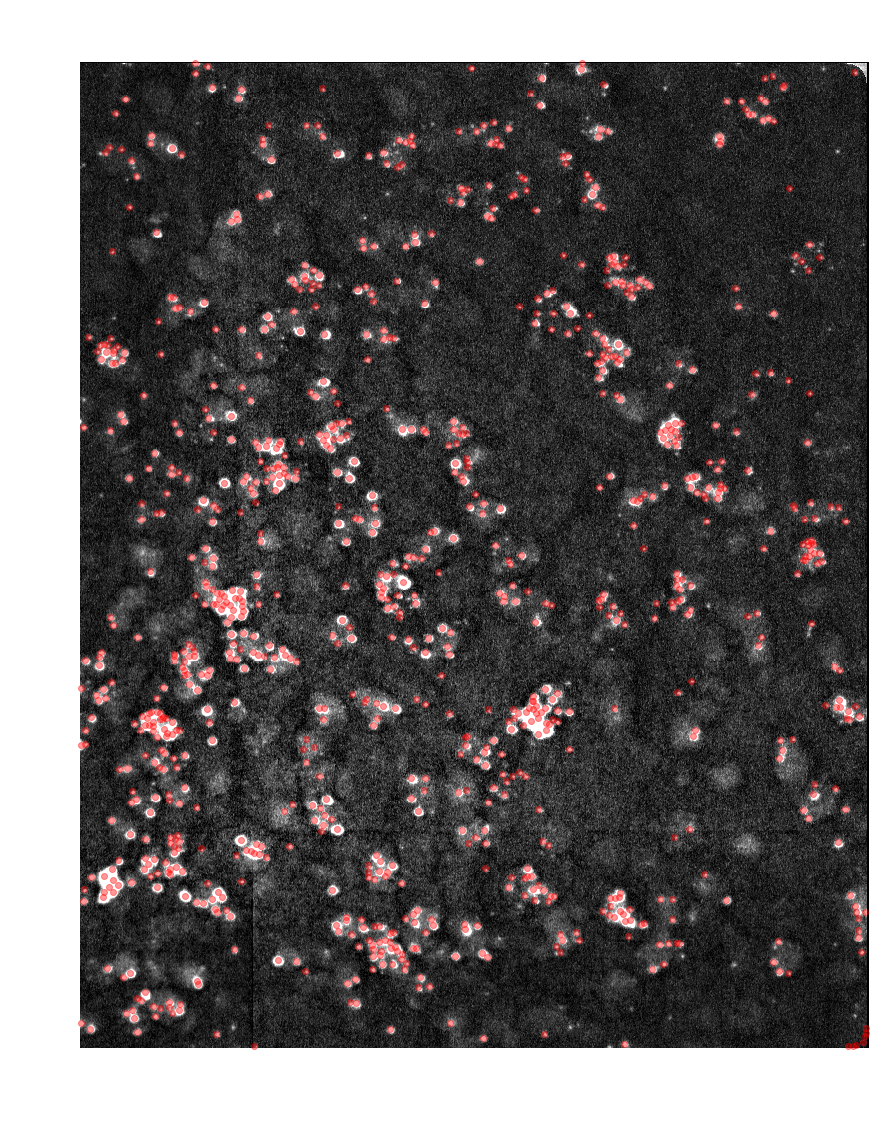

In [385]:
plot_on_image(skimage.exposure.rescale_intensity(registered.get_slice({Indices.ROUND: 0, Indices.CH:0})[0][0, :, :]), results[0, 0])

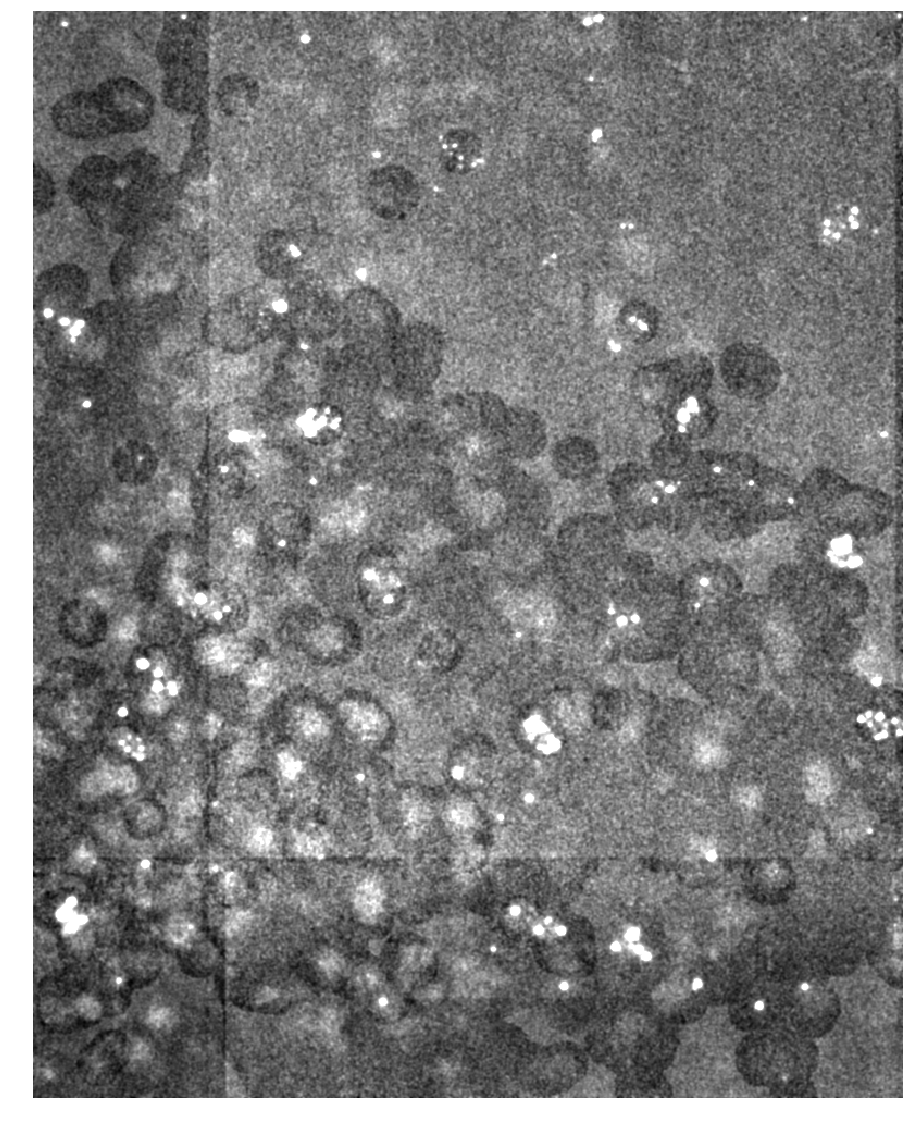

In [349]:
showit.image(skimage.exposure.rescale_intensity(skimage.filters.gaussian(registered.get_slice({Indices.CH: 1, Indices.ROUND: 0})[0][0, :, :], sigma=1)), 
             size=20, clim=(0, 0.05)) 

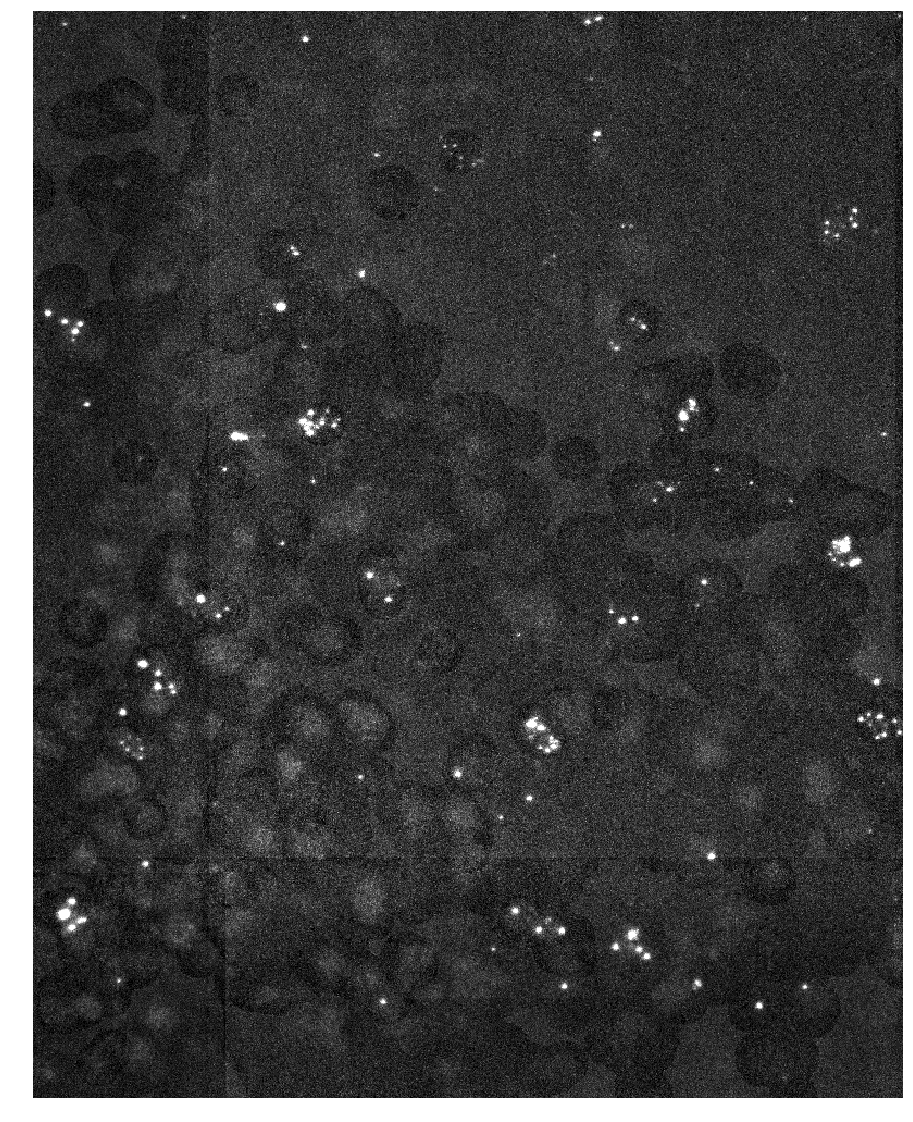

In [333]:
showit.image(skimage.exposure.rescale_intensity(registered.get_slice({Indices.CH: 1, Indices.ROUND: 0})[0][0, :, :]), clim=(0, 0.1), size=20)

In [280]:
?plt.imshow

Signature: plt.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=None, filternorm=1, filterrad=4.0, imlim=None, resample=None, url=None, hold=None, data=None, **kwargs)
Docstring:
Display an image on the axes.

Parameters
----------
X : array_like, shape (n, m) or (n, m, 3) or (n, m, 4)
    Display the image in `X` to current axes.  `X` may be an
    array or a PIL image. If `X` is an array, it
    can have the following shapes and types:

    - MxN -- values to be mapped (float or int)
    - MxNx3 -- RGB (float or uint8)
    - MxNx4 -- RGBA (float or uint8)

    MxN arrays are mapped to colors based on the `norm` (mapping
    scalar to scalar) and the `cmap` (mapping the normed scalar to
    a color).

    Elements of RGB and RGBA arrays represent pixels of an MxN image.
    All values should be in the range [0 .. 1] for floats or
    [0 .. 255] for integers.  Out-of-range values will be clipped to
    th

In [271]:
results[0][0, :]

array([0.00e+00, 9.97e+02, 7.88e+02, 5.00e-01])

In [248]:
gsd = SpotFinder.GaussianSpotDetector(
    min_sigma=2, max_sigma=5, num_sigma=10, threshold=0.002, overlap=0.5, reference_image_from_max_projection=True
)

In [250]:
registered.shape

OrderedDict([(<Indices.ROUND: 'r'>, 3),
             (<Indices.CH: 'c'>, 4),
             (<Indices.Z: 'z'>, 1),
             ('y', 1000),
             ('x', 800)])

In [249]:
intensities = gsd.run(registered)

ValueError: Empty data passed with indices specified.

In [20]:
codebook = exp.codebook

In [44]:
psd = SpotFinder.PixelSpotDetector(codebook, distance_threshold=0.51, magnitude_threshold=0.0, min_area=0, max_area=np.inf, metric='euclidean')

In [45]:
pixel_results, ccdr = psd.run(background_subtracted)

In [39]:
import starfish.plot
import pandas as pd

In [40]:
pd.Series(*np.unique(codebook.decode_per_round_max(peak_results)['target'], return_counts=True)[::-1])

nan    9577
dtype: int64

In [46]:
decoded_peak_results = codebook.metric_decode(peak_results, max_distance=0.517, min_intensity=0, norm_order=2)

In [50]:
ccdr.decoded_image.shape

(17, 1000, 800)

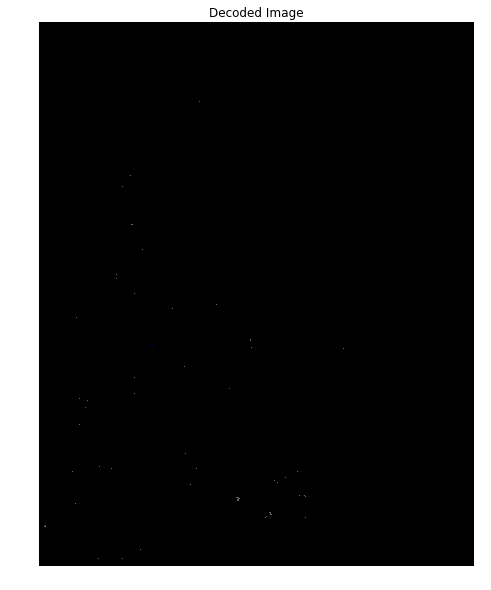

In [54]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 10))
starfish.plot.decoded_spots(decoded_image=ccdr.decoded_image[10], ax=ax)

In [33]:
proj_image = background_subtracted.max_proj(Indices.CH, Indices.ROUND, Indices.Z)

In [92]:
import showit

(array([7.57828e+05, 3.39890e+04, 6.11000e+03, 1.45800e+03, 4.06000e+02,
        1.40000e+02, 4.60000e+01, 9.00000e+00, 1.20000e+01, 2.00000e+00]),
 array([8.6671324e-05, 5.3830788e-04, 9.8994444e-04, 1.4415809e-03,
        1.8932174e-03, 2.3448539e-03, 2.7964904e-03, 3.2481272e-03,
        3.6997637e-03, 4.1514002e-03, 4.6030367e-03], dtype=float32),
 <a list of 10 Patch objects>)

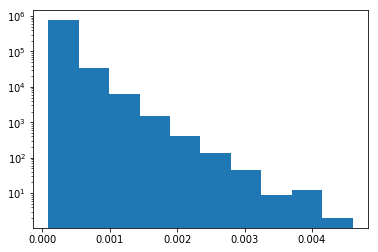

In [95]:
plt.hist(np.ravel(proj_image), log=True)

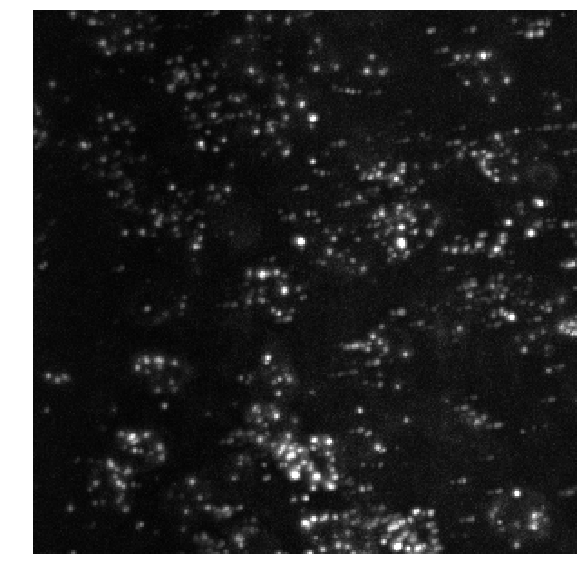

In [102]:
showit.image(proj_image[300:600, :300], clim=(0.0001, 0.002), size=10)